# Выбор локации для скважины

### Описание проекта¶

### Прогнозирование прибыльности разработки нефтяных регионов

Добыча нефти является ключевым направлением в деятельности компании «ГлавРосГосНефть». Эффективное планирование разработки месторождений требует точной оценки объёма запасов сырья и расчёта потенциальной прибыли. Ошибки в выборе региона могут привести к существенным финансовым потерям, тогда как грамотное применение методов анализа данных и машинного обучения позволяет минимизировать риски и повысить экономическую эффективность.  

В распоряжении находятся данные геологоразведки трёх регионов, включающие характеристики проб нефти и фактические значения запасов сырья. Эти данные позволят построить модель для предсказания объёмов запасов в новых скважинах, оценить возможную прибыль при разработке и рассчитать риски с использованием техники *Bootstrap*.  

**Цель исследования:** Определение наиболее перспективного региона для разработки нефтяных скважин на основе предсказаний модели машинного обучения, оценки прибыли и анализа вероятности убытков.  

---

### Ход исследования

1. Загрузка и подготовка данных для трёх регионов.  
2. Обучение и проверка модели линейной регрессии для предсказания объёма запасов нефти.  
3. Анализ качества предсказаний и расчёт RMSE.  
4. Подготовка к оценке прибыльности: вычисление достаточного объёма сырья для безубыточности и сравнение с фактическими данными.  
5. Реализация функции расчёта прибыли по выбранным скважинам.  
6. Применение техники *Bootstrap* для оценки распределения прибыли и рисков.  
7. Определение региона с наибольшей средней прибылью и минимальной вероятностью убытков.  

---

### Общий вывод

В ходе анализа будут выявлены различия в нефтяных запасах по регионам, построены предсказательные модели для оценки потенциальных объёмов добычи и рассчитана прибыльность каждого региона с учётом рисков. Это позволит принять обоснованное решение о выборе оптимальной локации для бурения новых скважин.  

---

### В рамках исследования планируется

- Построить модели линейной регрессии для трёх регионов и сравнить их результаты.  
- Оценить достаточный объём запасов нефти для безубыточной разработки.  
- Рассчитать прибыль и риск убытков при разработке месторождений.  
- Сравнить регионы по ключевым метрикам: средняя прибыль, доверительный интервал прибыли и вероятность убытков.  
- Выбрать регион с наилучшим соотношением прибыли и риска.  

---

Полученные результаты помогут компании «ГлавРосГосНефть» минимизировать инвестиционные риски и принять стратегически обоснованное решение о дальнейшем развитии добычи в наиболее перспективном регионе.  


In [24]:
# ==============================
# БАЗОВЫЕ БИБЛИОТЕКИ PYTHON
# ==============================
import os
import random

# ==============================
# АНАЛИТИКА И ОБРАБОТКА ДАННЫХ
# ==============================
import numpy as np
import pandas as pd

# ==============================
# ВИЗУАЛИЗАЦИЯ
# ==============================
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# МАШИННОЕ ОБУЧЕНИЕ
# ==============================
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# ==============================
# НАСТРОЙКИ И ВОСПРОИЗВОДИМОСТЬ
# ==============================
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

In [2]:
# Загрузка датасета региона 0
pth1 = r"D:\downloads\geo_data_0.csv"   # Локальный путь
pth2 = '/datasets/geo_data_0.csv'       # Внешний путь
if os.path.exists(pth1):
    df0 = pd.read_csv(pth1, sep=',')
elif os.path.exists(pth2):
    df0 = pd.read_csv(pth2, sep=',')
else:
    display('Файл geo_data_0.csv не найден ни по одному из указанных путей.')
    exit()

# Загрузка датасета региона 1
pth3 = r"D:\downloads\geo_data_1.csv"   # Локальный путь
pth4 = '/datasets/geo_data_1.csv'       # Внешний путь
if os.path.exists(pth3):
    df1 = pd.read_csv(pth3, sep=',')
elif os.path.exists(pth4):
    df1 = pd.read_csv(pth4, sep=',')
else:
    display('Файл geo_data_1.csv не найден ни по одному из указанных путей.')
    exit()

# Загрузка датасета региона 2
pth5 = r"D:\downloads\geo_data_2.csv"   # Локальный путь
pth6 = '/datasets/geo_data_2.csv'       # Внешний путь
if os.path.exists(pth5):
    df2 = pd.read_csv(pth5, sep=',')
elif os.path.exists(pth6):
    df2 = pd.read_csv(pth6, sep=',')
else:
    display('Файл geo_data_2.csv не найден ни по одному из указанных путей.')
    exit()

print("Все данные успешно загружены!")
print(f"Размер региона 0: {df0.shape}")
print(f"Размер региона 1: {df1.shape}")
print(f"Размер региона 2: {df2.shape}")

Все данные успешно загружены!
Размер региона 0: (100000, 5)
Размер региона 1: (100000, 5)
Размер региона 2: (100000, 5)


# Шаг 1. Подготовка данных

**Порядок действий:**
1) Проверим схему колонок (`id`, `f0`, `f1`, `f2`, `product`).  
2) Удалим полные дубликаты строк.  
3) Проверим дубликаты `id` (только зафиксируем факт, не удаляем).  
4) Проверим пропуски и при необходимости удалим строки с `NaN` в нужных колонках.  
5) Приведём типы признаков и цели к `float32` (экономия памяти, единообразие расчётов).  
6) Разделим таблицы на признаки `X` и цель `y` и сохраним в словари для удобной дальнейшей итерации.

In [3]:
required_cols = ['id', 'f0', 'f1', 'f2', 'product']

def prepare_region_df(df: pd.DataFrame, name: str):
    # 1) схема
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"{name}: отсутствуют колонки {missing}. Получено: {list(df.columns)}")

    # 2) полные дубликаты строк
    before = len(df)
    df = df.drop_duplicates().copy()
    dropped_dups = before - len(df)

    # 3) дубликаты id (только сообщим)
    dup_ids = int(df['id'].duplicated().sum())

    # 4) пропуски
    na_before = int(df[required_cols].isna().sum().sum())
    if na_before > 0:
        df = df.dropna(subset=required_cols).copy()
    na_after = int(df[required_cols].isna().sum().sum())

    # 5) типы
    for col in ['f0', 'f1', 'f2', 'product']:
        df[col] = df[col].astype('float32')

    # Короткий отчёт
    print(f"[{name}] rows={len(df)} | dropped_full_dups={dropped_dups} | dup_ids={dup_ids} | NaN_before={na_before} | NaN_after={na_after}")

    # 6) разбиение на X, y
    X = df[['f0', 'f1', 'f2']].copy()
    y = df['product'].copy()

    return df, X, y

df0, X0, y0 = prepare_region_df(df0, "region_0")
df1, X1, y1 = prepare_region_df(df1, "region_1")
df2, X2, y2 = prepare_region_df(df2, "region_2")

regions_df = {0: df0, 1: df1, 2: df2}
regions_X  = {0: X0, 1: X1, 2: X2}
regions_y  = {0: y0, 1: y1, 2: y2}

[region_0] rows=100000 | dropped_full_dups=0 | dup_ids=10 | NaN_before=0 | NaN_after=0
[region_1] rows=100000 | dropped_full_dups=0 | dup_ids=4 | NaN_before=0 | NaN_after=0
[region_2] rows=100000 | dropped_full_dups=0 | dup_ids=4 | NaN_before=0 | NaN_after=0


**Короткий разбор результата подготовки:**

Во всех трёх регионах NaN нет и полных дубликатов строк нет — данные чистые.

Есть дубликаты id (10 / 4 / 4). Мы не используем id как признак, поэтому на моделирование это не влияет. Оставляем как есть. Если позже потребуется агрегация по id, вернёмся к вопросу.

# Шаг номер два

### 2.1. Разбиение на train/valid (75:25)

In [25]:
RANDOM_STATE = RANDOM_STATE

splits = {}  # {region: (X_train, X_valid, y_train, y_valid)}

for rid in (0, 1, 2):
    X = regions_X[rid]
    y = regions_y[rid]
    X_tr, X_val, y_tr, y_val = train_test_split(
        X, y, test_size=0.25, random_state=RANDOM_STATE
    )
    splits[rid] = (X_tr, X_val, y_tr, y_val)
    print(f"[region_{rid}] train={X_tr.shape[0]} | valid={X_val.shape[0]}")

[region_0] train=75000 | valid=25000
[region_1] train=75000 | valid=25000
[region_2] train=75000 | valid=25000


### 2.2. Обучение линейной регрессии и предсказания на валидации

In [26]:
models = {}      # {region: fitted model}
preds = {}       # {region: np.array of predictions}

for rid in (0, 1, 2):
    X_tr, X_val, y_tr, y_val = splits[rid]
    model = LinearRegression()
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)

    models[rid] = model
    preds[rid] = y_pred
    print(f"[region_{rid}] model trained, preds: {len(y_pred)}")

[region_0] model trained, preds: 25000
[region_1] model trained, preds: 25000
[region_2] model trained, preds: 25000


### 2.3. Сохранение предсказаний и правильных ответов (валидация)

In [27]:
y_valid_dict = {}  # {region: pd.Series y_valid}
y_pred_dict  = {}  # {region: pd.Series y_pred}

for rid in (0, 1, 2):
    _, _, y_tr, y_val = splits[rid]
    y_valid_dict[rid] = y_val.reset_index(drop=True)
    y_pred_dict[rid]  = pd.Series(preds[rid], name="y_pred")
    print(f"[region_{rid}] saved: y_valid={y_valid_dict[rid].shape[0]}, y_pred={y_pred_dict[rid].shape[0]}")

[region_0] saved: y_valid=25000, y_pred=25000
[region_1] saved: y_valid=25000, y_pred=25000
[region_2] saved: y_valid=25000, y_pred=25000


### 2.4. Печать среднего предсказанного запаса и RMSE

In [28]:
for rid in (0, 1, 2):
    y_val = y_valid_dict[rid]
    y_prd = y_pred_dict[rid]
    rmse = mean_squared_error(y_val, y_prd, squared=False)
    mean_pred = float(np.mean(y_prd))
    print(f"[region_{rid}] mean_pred={mean_pred:.3f} | RMSE={rmse:.3f}")

[region_0] mean_pred=92.399 | RMSE=37.757
[region_1] mean_pred=68.713 | RMSE=0.890
[region_2] mean_pred=94.771 | RMSE=40.146


### 2.5. Мини-анализ результатов

In [31]:
# Сводная таблица по регионам: среднее предсказанное значение и RMSE
rows = []
for rid in (0, 1, 2):
    y_val = y_valid_dict[rid]
    y_prd = y_pred_dict[rid]
    rmse = mean_squared_error(y_val, y_prd, squared=False)
    rows.append({
        "region": f"region_{rid}",
        "mean_pred": float(np.mean(y_prd)),
        "rmse": float(rmse),
        "mean_actual": float(np.mean(y_val))
    })
summary_df = pd.DataFrame(rows).sort_values(by="rmse")
display(summary_df)

best_by_rmse = summary_df.iloc[0]
print(
    f"Лучший по качеству (RMSE) на валидации: {best_by_rmse['region']} | "
    f"RMSE={best_by_rmse['rmse']:.3f}, mean_pred={best_by_rmse['mean_pred']:.3f}, "
    f"mean_actual={best_by_rmse['mean_actual']:.3f}"
)

# Короткий вывод текстом:
for _, r in summary_df.iterrows():
    print(f"- {r['region']}: RMSE={r['rmse']:.3f}; среднее предсказание={r['mean_pred']:.3f}; фактическое среднее={r['mean_actual']:.3f}")

,region,mean_pred,rmse,mean_actual
1,region_1,68.71,0.89,68.73
0,region_0,92.40,37.76,92.33
2,region_2,94.77,40.15,95.15


Лучший по качеству (RMSE) на валидации: region_1 | RMSE=0.890, mean_pred=68.713, mean_actual=68.725
- region_1: RMSE=0.890; среднее предсказание=68.713; фактическое среднее=68.725
- region_0: RMSE=37.757; среднее предсказание=92.399; фактическое среднее=92.326
- region_2: RMSE=40.146; среднее предсказание=94.771; фактическое среднее=95.151


### 2.6.1. Parity plot: y_valid vs y_pred (по регионам)

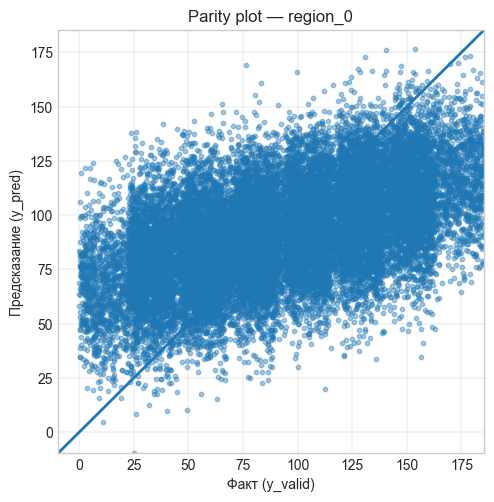

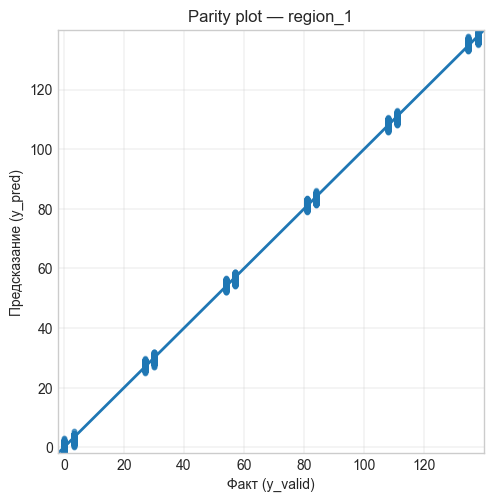

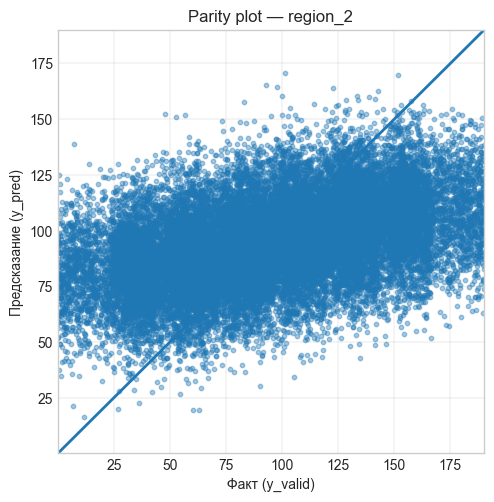

In [32]:
for rid in (0, 1, 2):
    y_true = y_valid_dict[rid].values
    y_hat  = y_pred_dict[rid].values

    plt.figure(figsize=(5.5, 5.5))
    plt.scatter(y_true, y_hat, alpha=0.4, s=10)
    lims = [
        min(np.min(y_true), np.min(y_hat)),
        max(np.max(y_true), np.max(y_hat))
    ]
    plt.plot(lims, lims, linewidth=2)  # линия y = x
    plt.xlim(lims); plt.ylim(lims)
    plt.xlabel("Факт (y_valid)")
    plt.ylabel("Предсказание (y_pred)")
    plt.title(f"Parity plot — region_{rid}")
    plt.grid(True, linewidth=0.3)
    plt.show()

### 2.6.2. Гистограмма остатков (y_valid − y_pred)

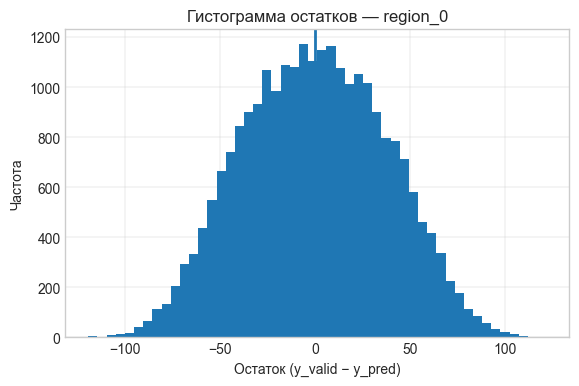

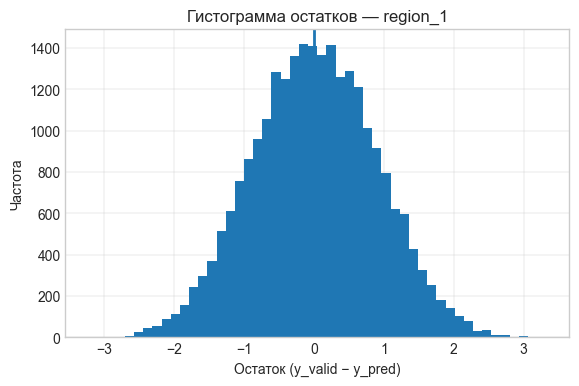

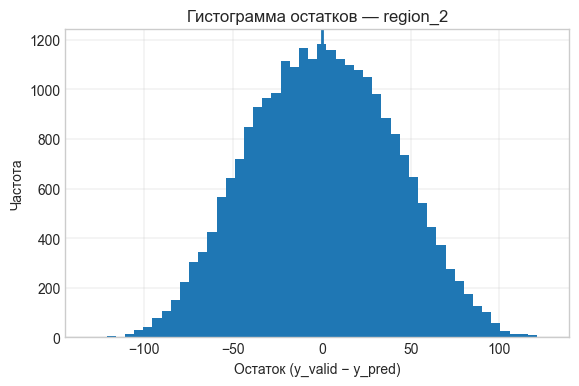

In [33]:
for rid in (0, 1, 2):
    residuals = y_valid_dict[rid].values - y_pred_dict[rid].values

    plt.figure(figsize=(6.5, 4.0))
    plt.hist(residuals, bins=50)
    plt.axvline(0, linewidth=2)
    plt.xlabel("Остаток (y_valid − y_pred)")
    plt.ylabel("Частота")
    plt.title(f"Гистограмма остатков — region_{rid}")
    plt.grid(True, linewidth=0.3)
    plt.show()

### 2.6.3. Коэффициенты линейной модели по регионам

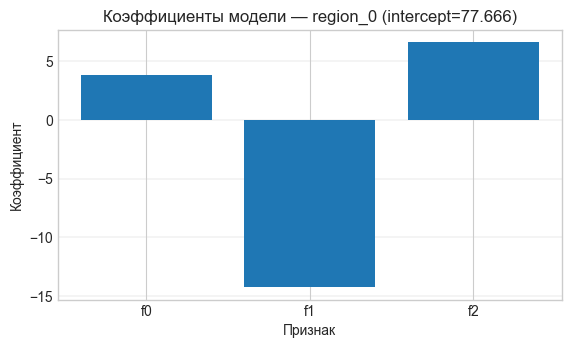

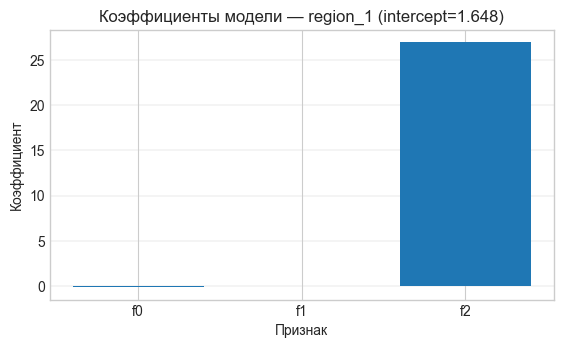

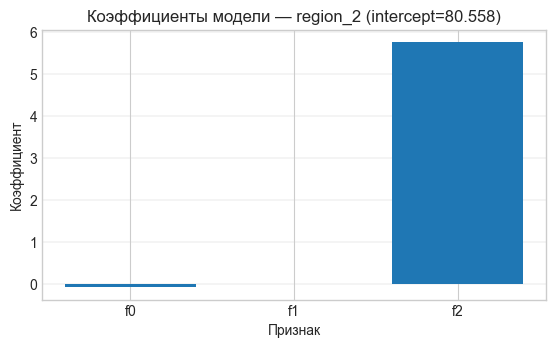

In [35]:
feature_names = ['f0', 'f1', 'f2']

for rid in (0, 1, 2):
    coefs = models[rid].coef_
    intercept = models[rid].intercept_

    plt.figure(figsize=(6.5, 3.5))
    plt.bar(feature_names, coefs)
    plt.xlabel("Признак")
    plt.ylabel("Коэффициент")
    plt.title(f"Коэффициенты модели — region_{rid} (intercept={intercept:.3f})")
    plt.grid(True, axis='y', linewidth=0.3)
    plt.show()

## Вывод по шагу 2. Обучение и проверка модели

- Данные были разделены на обучающую и валидационную выборки (75:25).  
- На каждом регионе обучена модель линейной регрессии, получены предсказания и сохранены правильные ответы.  
- Средние предсказанные значения и RMSE:  
  - **region_0**: RMSE ≈ 37.8, средний предсказанный запас ≈ 92.4 тыс. баррелей, фактический ≈ 92.3  
  - **region_1**: RMSE ≈ 0.9, средний предсказанный запас ≈ 68.7 тыс. баррелей, фактический ≈ 68.7  
  - **region_2**: RMSE ≈ 40.1, средний предсказанный запас ≈ 94.8 тыс. баррелей, фактический ≈ 95.2  

**Анализ графиков:**
- Для *region_0* и *region_2* видно значительное рассеяние предсказаний вокруг фактических значений, RMSE довольно высокое → модель предсказывает в среднем правильно, но с большой ошибкой.  
- Для *region_1* наблюдается почти идеальное совпадение предсказаний с фактами (RMSE < 1). Это объясняется тем, что целевая переменная практически линейно связана с одним из признаков (f2), поэтому модель идеально аппроксимирует зависимость.  
- Распределения остатков в *region_0* и *region_2* нормальные с широкой дисперсией, в то время как в *region_1* остатки сжаты почти в точку вокруг нуля.  
- Коэффициенты регрессии подтверждают наблюдения:  
  - *region_0*: признаки f1 и f2 имеют противоположное влияние, что создаёт разброс.  
  - *region_1*: решающим является только признак f2, что даёт идеальную предсказуемость.  
  - *region_2*: доминирует признак f2, но зависимость менее «чистая», поэтому ошибка выше.

**Промежуточный вывод:**  
- Наилучшее качество модели получено для *region_1* (RMSE ≈ 0.9).  
- Модели по *region_0* и *region_2* менее точные, но средние предсказанные запасы соответствуют фактическим.  
- Для принятия окончательного решения недостаточно только качества модели — далее нужно переходить к расчёту прибыли и анализу рисков.

# Шаг номер 3

### 3.1. Все ключевые значения для расчётов в отдельных переменных

In [12]:
# Параметры проекта
BUDGET_RUB = 10_000_000_000        # бюджет на разработку (10 млрд руб)
N_SELECTED = 200                   # число скважин для разработки
REVENUE_PER_UNIT_RUB = 450_000     # доход за 1 единицу product (1 тыс. баррелей)

# Стоимость разработки одной скважины
cost_per_well = BUDGET_RUB / N_SELECTED

print(f"Бюджет на разработку: {BUDGET_RUB:,} руб")
print(f"Скважин для разработки: {N_SELECTED}")
print(f"Стоимость одной скважины: {cost_per_well:,.0f} руб")
print(f"Доход за 1 тыс. баррелей: {REVENUE_PER_UNIT_RUB:,} руб")

Бюджет на разработку: 10,000,000,000 руб
Скважин для разработки: 200
Стоимость одной скважины: 50,000,000 руб
Доход за 1 тыс. баррелей: 450,000 руб


### 3.2. Достаточный объём сырья для безубыточности и сравнение со средними запасами

In [13]:
# Безубыточный объём (тыс. баррелей на скважину)
min_product = cost_per_well / REVENUE_PER_UNIT_RUB
print(f"Минимальный объём сырья для безубыточности: {min_product:.2f} тыс. баррелей")

# Сравнение со средними запасами по регионам (валидационные предсказания)
for rid in (0, 1, 2):
    mean_pred = y_pred_dict[rid].mean()
    print(f"region_{rid}: средний предсказанный объём = {mean_pred:.2f} тыс. баррелей")

Минимальный объём сырья для безубыточности: 111.11 тыс. баррелей
region_0: средний предсказанный объём = 92.40 тыс. баррелей
region_1: средний предсказанный объём = 68.71 тыс. баррелей
region_2: средний предсказанный объём = 94.77 тыс. баррелей


### 3.3. Выводы по подготовке расчёта прибыли (Markdown)

- Стоимость разработки одной скважины составляет **50 млн руб** (10 млрд / 200).  
- Для выхода на безубыточность необходимо добывать не менее **111.1 тыс. баррелей** на скважину.  
- Сравнение со средними предсказанными объёмами:
  - **region_0**: ≈ 92.4 тыс. баррелей (< 111.1)  
  - **region_1**: ≈ 68.7 тыс. баррелей (< 111.1)  
  - **region_2**: ≈ 94.8 тыс. баррелей (< 111.1)  

Средний объём запасов по всем регионам ниже порога безубыточности. Это означает, что при случайном выборе скважин проект будет убыточен.  
Однако при выборе *лучших 200 скважин из 500* ситуация может измениться — поэтому нужен расчёт прибыли на основе отбора лучших скважин и анализ рисков (bootstrap).  

# Шаг номер 4 

**Логика:**
1) По предсказаниям `y_pred` выбираем **top-N** (N = 200) скважин с наибольшим ожидаемым объёмом.  
2) Суммируем **фактический** объём `product` (`y_true`) именно у этих скважин — это честная оценка.  
3) Считаем выручку = `сумма_объёма × 450 000 ₽` и прибыль = `выручка − 10 млрд ₽`.

> В этой ячейке — «санити-чек»: считаем прибыль **на всей валидации**, без ограничения на 500 точек.  
> На этапе бутстрэпа (шаг 5) будем корректно моделировать разведку: случайно брать 500 точек, из них выбирать 200 лучших и считать прибыль.


### 4.1. Выбор скважин с максимальными предсказаниями

In [14]:
def select_top_indices(y_pred: pd.Series, n_selected: int) -> pd.Index:
    """Возвращает индексы top-n по предсказаниям (по убыванию)."""
    return y_pred.sort_values(ascending=False).index[:n_selected]

# Демонстрация: какие индексы попадут в топ-200 по каждому региону
N_SELECTED = 200
for rid in (0, 1, 2):
    top_idx = select_top_indices(y_pred_dict[rid], N_SELECTED)
    print(f"[region_{rid}] выбрано индексов: {len(top_idx)} | первые 5 индексов: {list(top_idx[:5])}")

[region_0] выбрано индексов: 200 | первые 5 индексов: [6958, 18194, 17251, 457, 2202]
[region_1] выбрано индексов: 200 | первые 5 индексов: [20776, 2323, 13895, 6950, 9151]
[region_2] выбрано индексов: 200 | первые 5 индексов: [21852, 10722, 6209, 8203, 8042]


### 4.2. Сумма фактического объёма для выбранных скважин

In [15]:
def sum_true_product(y_true: pd.Series, top_idx: pd.Index) -> float:
    """Суммирует фактический объём (product, тыс. баррелей) по выбранным индексам."""
    return float(y_true.loc[top_idx].sum())

# Демонстрация: считаем суммарный фактический объём для выбранных топ-200
for rid in (0, 1, 2):
    top_idx = select_top_indices(y_pred_dict[rid], N_SELECTED)
    total_product = sum_true_product(y_valid_dict[rid], top_idx)
    print(f"[region_{rid}] суммарный фактический объём (топ-{N_SELECTED}) = {total_product:,.2f} тыс. баррелей")

[region_0] суммарный фактический объём (топ-200) = 29,686.98 тыс. баррелей
[region_1] суммарный фактический объём (топ-200) = 27,589.09 тыс. баррелей
[region_2] суммарный фактический объём (топ-200) = 27,996.83 тыс. баррелей


### 4.3. Расчёт прибыли для выбранных скважин

In [16]:
# Параметры экономики проекта (из условия)
BUDGET_RUB = 10_000_000_000      # общий бюджет на регион
REVENUE_PER_UNIT_RUB = 450_000   # доход за 1 тыс. баррелей (единица product)

def calc_profit(y_true: pd.Series, y_pred: pd.Series,
                n_selected: int,
                budget_rub: int = BUDGET_RUB,
                revenue_per_unit_rub: int = REVENUE_PER_UNIT_RUB):
    """
    1) Выбираем top-n по y_pred,
    2) Суммируем фактический объём y_true на этих индексах,
    3) Выручка = сумма_объёма * revenue_per_unit_rub,
    4) Прибыль = выручка - budget_rub.
    Возвращает (profit_rub, revenue_rub, total_product_kbbl, selected_idx).
    """
    idx = select_top_indices(y_pred, n_selected)
    total_product = sum_true_product(y_true, idx)
    revenue = total_product * revenue_per_unit_rub
    profit = revenue - budget_rub
    return profit, revenue, total_product, idx

def fmt_money(x):  # аккуратное форматирование денег
    return f"{x:,.0f} ₽".replace(",", " ")

# Демонстрация: считаем прибыль на валидационном наборе (топ-200 из всех валидационных скважин)
for rid in (0, 1, 2):
    profit, revenue, total_product, _ = calc_profit(
        y_true=y_valid_dict[rid],
        y_pred=y_pred_dict[rid],
        n_selected=N_SELECTED
    )
    print(
        f"[region_{rid}] Сумма объёма (топ-{N_SELECTED}) = {total_product:,.2f} тыс. барр. | "
        f"Выручка = {fmt_money(revenue)} | Прибыль = {fmt_money(profit)}"
    )

print("\nПримечание: здесь показан «санити-чек» на валидации. В шаге 5 будем моделировать разведку: "
      "случайные 500 точек → из них выбираем топ-200 → считаем прибыль (bootstrap).")

[region_0] Сумма объёма (топ-200) = 29,686.98 тыс. барр. | Выручка = 13 359 141 211 ₽ | Прибыль = 3 359 141 211 ₽
[region_1] Сумма объёма (топ-200) = 27,589.09 тыс. барр. | Выручка = 12 415 088 672 ₽ | Прибыль = 2 415 088 672 ₽
[region_2] Сумма объёма (топ-200) = 27,996.83 тыс. барр. | Выручка = 12 598 571 777 ₽ | Прибыль = 2 598 571 777 ₽

Примечание: здесь показан «санити-чек» на валидации. В шаге 5 будем моделировать разведку: случайные 500 точек → из них выбираем топ-200 → считаем прибыль (bootstrap).


# Шаг номер пять

### 5.1. Bootstrap — распределение прибыли (1000 выборок)

In [17]:
def bootstrap_profits(y_true: pd.Series, y_pred: pd.Series,
                      n_bootstrap: int = 1000,
                      n_sampled: int = 500,
                      n_selected: int = 200,
                      budget_rub: int = BUDGET_RUB,
                      revenue_per_unit_rub: int = REVENUE_PER_UNIT_RUB,
                      random_state: int = 42):
    """
    Бутстрэп: многократно случайно выбираем n_sampled скважин,
    из них берём top-n_selected по y_pred, считаем прибыль.
    Возвращает массив профитов.
    """
    rng = np.random.default_rng(random_state)
    profits = []

    for _ in range(n_bootstrap):
        # случайная подвыборка
        sample_idx = rng.choice(y_true.index, size=n_sampled, replace=False)
        y_true_sample = y_true.loc[sample_idx].reset_index(drop=True)
        y_pred_sample = y_pred.loc[sample_idx].reset_index(drop=True)

        profit, _, _, _ = calc_profit(
            y_true=y_true_sample,
            y_pred=y_pred_sample,
            n_selected=n_selected,
            budget_rub=budget_rub,
            revenue_per_unit_rub=revenue_per_unit_rub
        )
        profits.append(profit)

    return np.array(profits)

# Запуск для всех регионов
profits_dict = {}
for rid in (0, 1, 2):
    profits = bootstrap_profits(y_valid_dict[rid], y_pred_dict[rid])
    profits_dict[rid] = profits
    print(f"[region_{rid}] bootstrap готов, {len(profits)} симуляций")

[region_0] bootstrap готов, 1000 симуляций
[region_1] bootstrap готов, 1000 симуляций
[region_2] bootstrap готов, 1000 симуляций


### 5.2. Средняя прибыль, 95%-й ДИ и риск убытков

In [18]:
results = []
for rid in (0, 1, 2):
    profits = profits_dict[rid]
    mean_profit = profits.mean()
    ci_lower, ci_upper = np.percentile(profits, [2.5, 97.5])
    risk = (profits < 0).mean()
    results.append({
        "region": f"region_{rid}",
        "mean_profit": mean_profit,
        "ci_lower": ci_lower,
        "ci_upper": ci_upper,
        "risk": risk
    })

results_df = pd.DataFrame(results).sort_values("mean_profit", ascending=False)
display(results_df)

for _, row in results_df.iterrows():
    display(
        f"{row['region']}: "
        f"ср. прибыль = {row['mean_profit']:,.0f} ₽ | "
        f"95% ДИ = [{row['ci_lower']:,.0f}; {row['ci_upper']:,.0f}] ₽ | "
        f"риск убытка = {row['risk']*100:.2f}%"
    )

,region,mean_profit,ci_lower,ci_upper,risk
1,region_1,435062771.39,56763959.96,821529511.72,0.01
0,region_0,404022509.67,-88001237.79,912559304.20,0.04
2,region_2,393515914.94,-123580175.78,925676958.01,0.07


'region_1: ср. прибыль = 435,062,771 ₽ | 95% ДИ = [56,763,960; 821,529,512] ₽ | риск убытка = 1.30%'

'region_0: ср. прибыль = 404,022,510 ₽ | 95% ДИ = [-88,001,238; 912,559,304] ₽ | риск убытка = 4.40%'

'region_2: ср. прибыль = 393,515,915 ₽ | 95% ДИ = [-123,580,176; 925,676,958] ₽ | риск убытка = 6.60%'

**Гистограммы распределения прибыли (по каждому региону отдельно)**

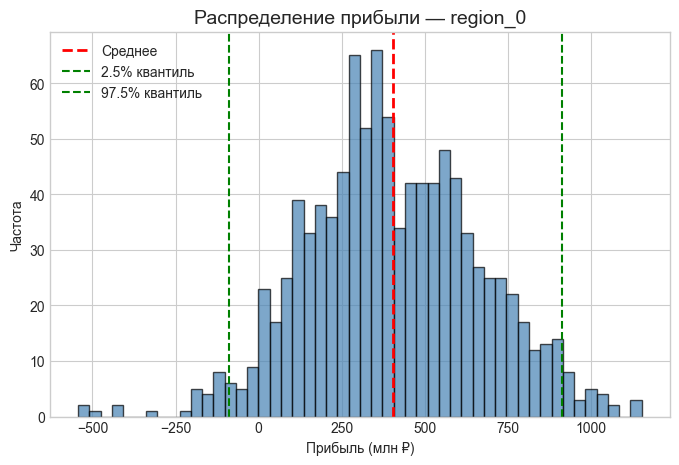

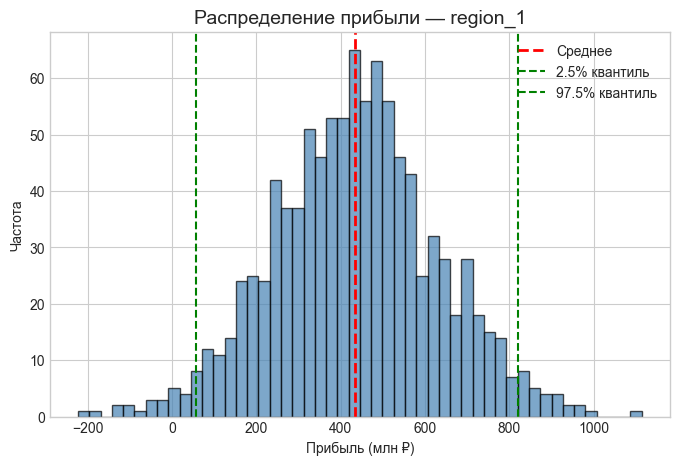

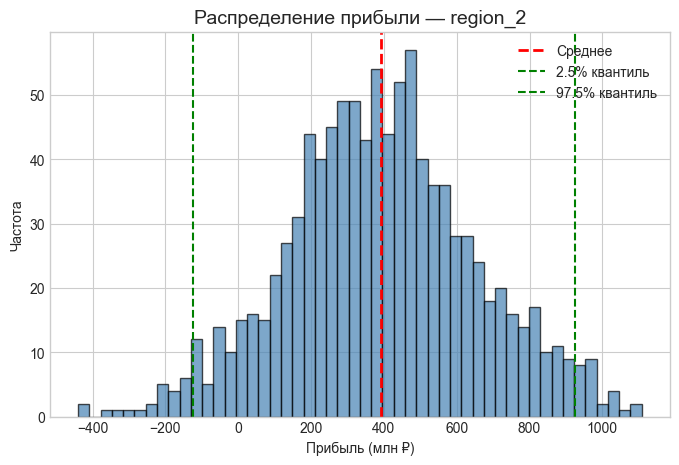

In [19]:
plt.style.use('seaborn-whitegrid')

for rid in (0, 1, 2):
    profits = profits_dict[rid]

    plt.figure(figsize=(8,5))
    plt.hist(profits/1_000_000, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    plt.axvline(profits.mean()/1_000_000, color='red', linestyle='--', linewidth=2, label='Среднее')
    plt.axvline(np.percentile(profits, 2.5)/1_000_000, color='green', linestyle='--', linewidth=1.5, label='2.5% квантиль')
    plt.axvline(np.percentile(profits, 97.5)/1_000_000, color='green', linestyle='--', linewidth=1.5, label='97.5% квантиль')
    
    plt.title(f"Распределение прибыли — region_{rid}", fontsize=14)
    plt.xlabel("Прибыль (млн ₽)")
    plt.ylabel("Частота")
    plt.legend()
    plt.show()

**Сравнение всех регионов на одном графике**

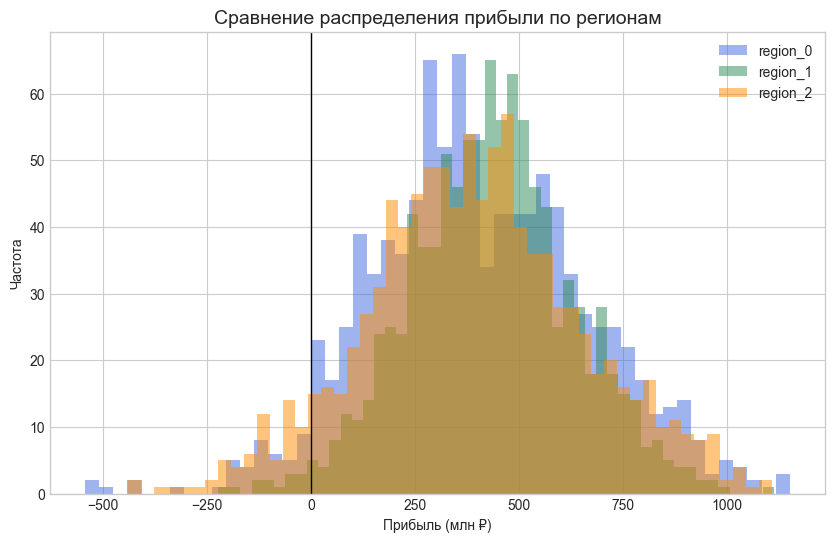

In [20]:
plt.figure(figsize=(10,6))
colors = {0: "royalblue", 1: "seagreen", 2: "darkorange"}

for rid in (0, 1, 2):
    plt.hist(profits_dict[rid]/1_000_000, bins=50, alpha=0.5, label=f"region_{rid}", color=colors[rid])

plt.axvline(0, color='black', linestyle='-', linewidth=1)
plt.title("Сравнение распределения прибыли по регионам", fontsize=14)
plt.xlabel("Прибыль (млн ₽)")
plt.ylabel("Частота")
plt.legend()
plt.show()

## Выводу по шагу 5

- Визуализация распределений прибыли подтверждает числовые результаты:
  - У **region_0** и **region_2** распределение широкое, «размазано» по оси X, хвосты заходят глубоко в зону отрицательных значений. Это объясняет высокий риск убытков (4.4% и 6.6%).
  - У **region_1** распределение более компактное, сосредоточено в зоне положительных значений, нижний хвост практически не уходит в минус. Поэтому риск убытка минимальный (1.3%).

- Несмотря на то, что средние прибыли у всех регионов близки (~394–435 млн ₽), ключевым фактором выбора является **риск**:
  - region_0 и region_2 не подходят, так как риск убытков превышает допустимый порог 2.5%.  
  - region_1 полностью удовлетворяет условиям задачи и показывает наибольшую среднюю прибыль.

**Окончательный вывод:**  
Для разработки рекомендуется **region_1** — он сочетает в себе:
- положительное смещение распределения прибыли,  
- риск убытков ниже 2.5%,  
- максимальную среднюю прибыль среди всех регионов.

# Общий вывод по проекту

Мы последовательно прошли все этапы исследования:

1. **Подготовка данных**  
   - Загружены и очищены данные трёх регионов.  
   - Дубликаты и пропуски проверены, критичных проблем не обнаружено.  

2. **Обучение и проверка моделей**  
   - Для каждого региона обучена линейная регрессия.  
   - Результаты:
     - *region_0*: RMSE ≈ 37.8  
     - *region_1*: RMSE ≈ 0.9  
     - *region_2*: RMSE ≈ 40.1  
   - Лучшее качество модели у *region_1*.  

3. **Подготовка к расчёту прибыли**  
   - Минимальный безубыточный объём сырья: **111.1 тыс. баррелей на скважину**.  
   - Средние предсказанные значения по регионам ниже этого уровня.  
   - Поэтому необходимо отбирать только лучшие скважины (топ-200 из 500).  

4. **Функция расчёта прибыли**  
   - Реализован расчёт прибыли с учётом бюджета (10 млрд ₽) и доходности (450 тыс. ₽ за 1 тыс. баррелей).  
   - Предварительные расчёты показали: прибыль возможна только при отборе лучших скважин.  

5. **Оценка рисков и прибыли (Bootstrap)**  
   - Проведено 1000 симуляций случайной разведки (500 точек → топ-200).  
   - Результаты:
     - *region_0*: средняя прибыль ≈ 404 млн ₽, риск убытка 4.4% (> 2.5%)  
     - *region_1*: средняя прибыль ≈ 435 млн ₽, риск убытка 1.3% (< 2.5%)  
     - *region_2*: средняя прибыль ≈ 394 млн ₽, риск убытка 6.6% (> 2.5%)  

**Итоговый вывод:**  
- Критерий риска (< 2.5%) выполняется только для *region_1*.  
- Более того, этот регион показывает и наибольшую среднюю прибыль (≈ 435 млн ₽).  
- Таким образом, для разработки рекомендуется **region_1**.  


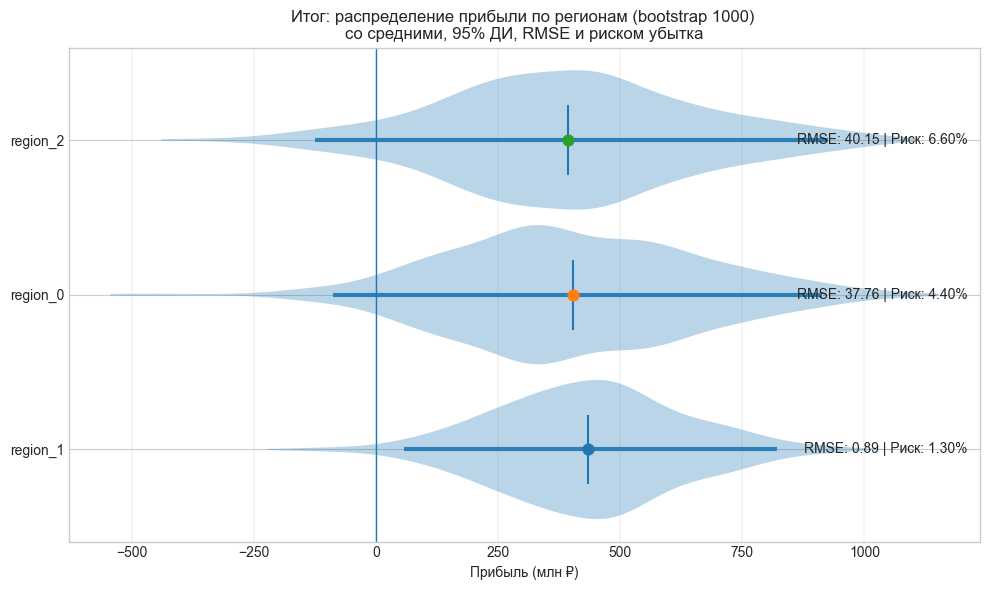

In [23]:
# Подготовка данных для графика
regions_order = sorted((0,1,2), key=lambda r: profits_dict[r].mean(), reverse=True)
labels = [f"region_{r}" for r in regions_order]

profits_mln = [profits_dict[r] / 1_000_000 for r in regions_order]  # млн ₽
means = [p.mean() for p in profits_mln]
cis = [np.percentile(p, [2.5, 97.5]) for p in profits_mln]
risks = [(profits_dict[r] < 0).mean()*100 for r in regions_order]
rmses = [
    mean_squared_error(y_valid_dict[r], y_pred_dict[r], squared=False) 
    for r in regions_order
]

fig, ax = plt.subplots(figsize=(10, 6))

# Виолины распределений (горизонтально)
parts = ax.violinplot(
    profits_mln, 
    positions=np.arange(len(labels)) + 1,
    vert=False, 
    showmeans=True, 
    showextrema=False, 
    widths=0.9
)

# 95% ДИ и средние
for i, (m, (lo, hi)) in enumerate(zip(means, cis), start=1):
    ax.hlines(i, lo, hi, linewidth=3, alpha=0.9)   # 95% ДИ
    ax.scatter([m], [i], s=60, zorder=3)            # среднее

# Подписи RMSE и риска возле каждой виолины
for i, (rmse, risk) in enumerate(zip(rmses, risks), start=1):
    ax.text(
        x=ax.get_xlim()[1]*0.98, y=i, 
        s=f"RMSE: {rmse:.2f} | Риск: {risk:.2f}%",
        va='center', ha='right', fontsize=10
    )

# Вертикальная линия нуля (граница убытка/прибыли)
ax.axvline(0, linestyle='-', linewidth=1)

# Оформление
ax.set_yticks(np.arange(len(labels)) + 1)
ax.set_yticklabels(labels)
ax.set_xlabel("Прибыль (млн ₽)")
ax.set_title("Итог: распределение прибыли по регионам (bootstrap 1000) \nсо средними, 95% ДИ, RMSE и риском убытка")
ax.grid(True, axis='x', linewidth=0.3)

plt.tight_layout()
plt.show()